Fitting 1 folds for each of 5 candidates, totalling 5 fits
[CV] END alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, max_iter=200; total time=12.3min
[CV] END alpha=0.01, hidden_layer_sizes=(50,), learning_rate=constant, max_iter=500; total time= 6.7min
[CV] END alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, max_iter=500; total time=30.5min
[CV] END alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, max_iter=200; total time=26.6min
[CV] END alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, max_iter=200; total time=17.6min
Best parameters for XGB Classifier:  {'max_iter': 500, 'learning_rate': 'constant', 'hidden_layer_sizes': (50,), 'alpha': 0.0001}


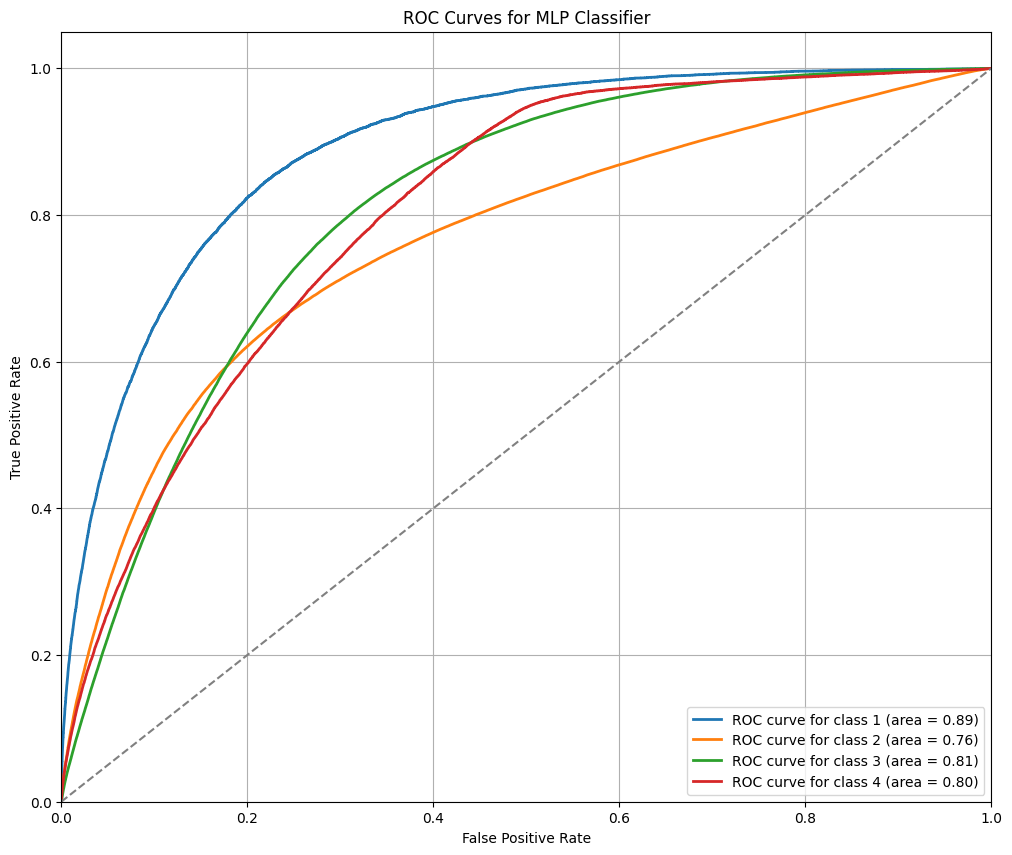

Accuracy:  0.6347
Classification Report:
              precision    recall  f1-score   support

           1       0.06      0.54      0.11      9362
           2       0.92      0.64      0.76    873568
           3       0.40      0.64      0.49    188164
           4       0.10      0.38      0.16     27219

    accuracy                           0.63   1098313
   macro avg       0.37      0.55      0.38   1098313
weighted avg       0.80      0.63      0.69   1098313



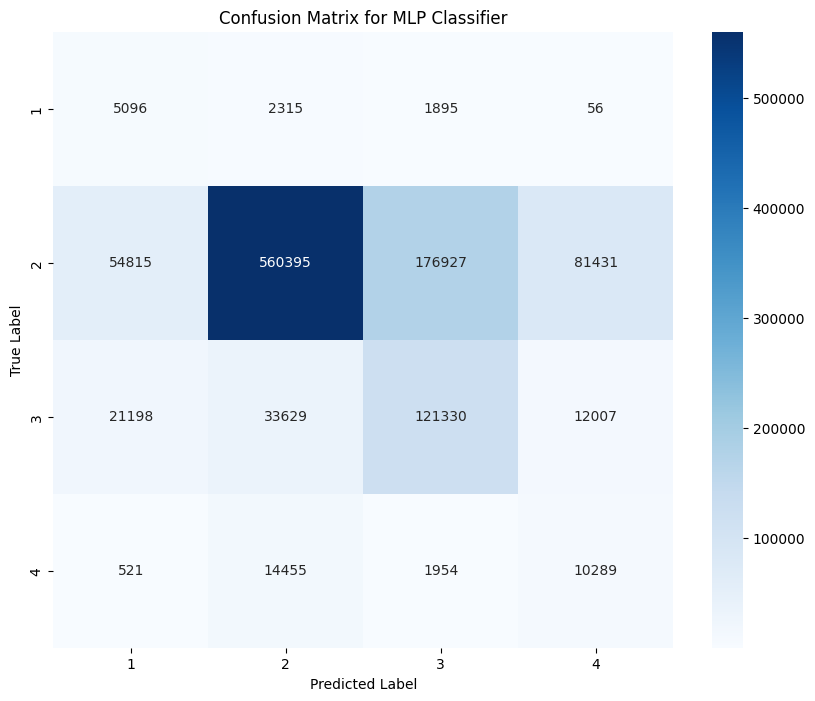

In [1]:
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV, PredefinedSplit
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, confusion_matrix
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns

train_data = pd.read_csv("Train_Set.csv")
val_data = pd.read_csv("Validation_Set.csv")
test_data = pd.read_csv('Test_Set.csv')

X_train = train_data.drop(columns=["Severity"])
y_train = train_data["Severity"]

X_test = test_data.drop(columns=["Severity"])
y_test = test_data["Severity"]

combined_data = pd.concat([train_data, val_data], axis=0)
X_combined = combined_data.drop(columns=["Severity"])
y_combined = combined_data["Severity"]

# Create an indicator array for the validation set split
split_index = [-1] * len(train_data) + [0] * len(val_data)
predefined_split = PredefinedSplit(test_fold=split_index)

mlp_params = {
    'hidden_layer_sizes': [(100,), (50,)],
    'max_iter': [500, 200], 
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive']
}

model_mlp_cv = RandomizedSearchCV(
    MLPClassifier(random_state=42),
    param_distributions= mlp_params,
    cv= predefined_split,
    n_iter= 5,
    n_jobs= 1,
    verbose=2,
    error_score='raise',
    scoring= 'neg_mean_squared_error'
)

model_mlp_cv.fit(X_combined, y_combined)

best_model_mlp = model_mlp_cv.best_estimator_
print("Best parameters for XGB Classifier: ", model_mlp_cv.best_params_)

y_pred = best_model_mlp.predict(X_test)

# Binarize the true labels for ROC curve (if multi-class)
classes = sorted(y_test.unique())
y_test_binarized = label_binarize(y_test, classes=classes)
n_classes = y_test_binarized.shape[1]

# Get probabilities for the ROC curve (required for AUC calculation)
# Using the best model from RandomizedSearchCV
y_prob = best_model_mlp.predict_proba(X_test)

# Binarize the true labels for ROC curve (for multi-class)
y_test_binarized = label_binarize(y_test, classes=classes)
n_classes = y_test_binarized.shape[1]

# Plot ROC curves for each class
plt.figure(figsize=(12, 10))

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'ROC curve for class {classes[i]} (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for MLP Classifier')
plt.legend(loc="lower right")
plt.grid()
plt.show()


accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy:  {accuracy:.4f}")
classification_report_str = classification_report(y_test, y_pred)
print("Classification Report:")
print(classification_report_str)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for MLP Classifier')
plt.show()